# Explore `meta-kaggle` Dataset

## --- Synthetically Generated Data

We test the potential of our estimation algorithm by synthetically generated data.

In [1]:
# std library
import os
import json
from pathlib import Path
from pprint import pprint
from datetime import datetime, timedelta
from typing import Sequence

# third-party
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numpy import typing as npt

# local
from synthetic_data import synthetic_data_simulation  # type: ignore

### 1. Model Setting

In [2]:
# Capacities & Total Innovation Uncertainty
param_theta = 1.0

param_c_i = 1.2
param_c_j = 1.5
param_sigma = 2.0
param_lambda = 1.0
param_r = 15.0

# Contest Time Duaration
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)
contest_days = (end_time - start_time).days
contest_seconds = int((end_time - start_time).total_seconds())
contest_hours = int(contest_seconds / 3600)
contest_timegrids: list[datetime] = np.arange(start_time, end_time, \
		timedelta(hours=1), dtype=datetime).tolist()
time_unit_2f = 1 / 24

print(contest_days, contest_hours, len(contest_timegrids))

90 2160 2160


### 2. Simulations

In [19]:
random_seed = 4321

time_grids, i_effort_dynamic, j_effort_dynamic, \
real_gap_dynamic, perceived_gap_dynamic, observed_gap_dynamic, \
observed_i_commits, observed_j_commits = synthetic_data_simulation(
	theta=param_theta,
	c_i=param_c_i,
	c_j=param_c_j,
	sigma=param_sigma,
	lamb=param_lambda,
	intensity_effort_ratio=param_r,
	hour_arrival_ub=1.0,
	start_time=start_time,
	end_time=end_time,
	time_unit=timedelta(hours=1),
	time_unit_2f=time_unit_2f,
	approx = True,  # using approximated version by default
	seed_brownian = random_seed + 0,
	seed_poisson = random_seed + 1,
	seed_uniform = random_seed + 2,
)

In [20]:
# pprint(observed_gap_dynamic)
pprint(f'number of i submissions = {len(observed_i_commits)}')
pprint(f'number of j submissions = {len(observed_j_commits)}')

'number of i submissions = 18'
'number of j submissions = 13'


In [21]:
def plot_ts_events(
		time_grids: Sequence[datetime] | npt.NDArray[np.datetime64],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		*,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios
	)
	# plot time series
	for ts_key, ts_val in ts.items():
		ax_main.plot(time_grids, ts_val, label=ts_key)
	ax_main.legend()
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1])
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height)
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

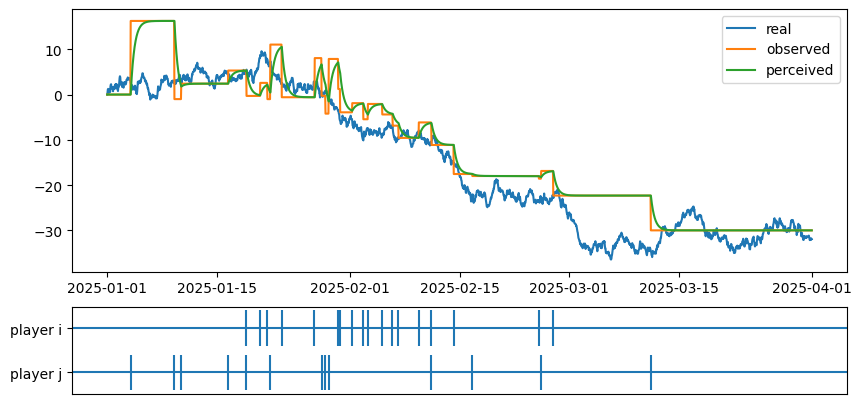

In [22]:
fig, _, _ = plot_ts_events(time_grids, {
			'real': real_gap_dynamic[:-1],
			'observed': observed_gap_dynamic[:-1],
			'perceived': perceived_gap_dynamic[:-1],
			#'effort gap (cumsum)': (i_effort_dynamic - j_effort_dynamic).cumsum(),
		}, {
			'player i': observed_i_commits,
			'player j': observed_j_commits,
	})

Goldstein, Yoav and Kolerman, Matan, Changing Minds: How Academic Fields Shape Political Attitudes (March 28, 2025). Available at SSRN: https://ssrn.com/abstract=5196889 or http://dx.doi.org/10.2139/ssrn.5196889

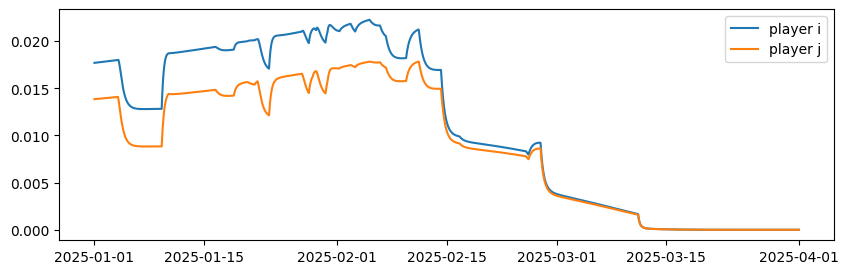

In [23]:
plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), i_effort_dynamic, label='player i')
plt.plot(np.array(time_grids), j_effort_dynamic, label='player j')
plt.legend()
plt.show()

In [24]:
# save the observed data
wd = os.getcwd()
wd_synthetic_data = os.path.join(wd, f'data_{contest_days}_{random_seed}.json')
roundint = lambda x: int(round(x))

with open(wd_synthetic_data, 'w') as f:
	json.dump({
		'theta': param_theta,
		'ratio': param_r,
		'N_Delta': roundint((end_time - start_time).total_seconds() / 3600),
		'Delta2f': time_unit_2f,
		'Ni': len(observed_i_commits),
		'Nj': len(observed_j_commits),
		'hat_t_i': [(dt - start_time).total_seconds() / 3600 for dt in observed_i_commits],
		'hat_t_j': [(dt - start_time).total_seconds() / 3600 for dt in observed_j_commits],
		'hat_y': observed_gap_dynamic.tolist(),
		'efforts_i': i_effort_dynamic.tolist(),
		'efforts_j': j_effort_dynamic.tolist(),
	}, f, indent=4)

### 3. Bayesian Inference

In [28]:
# import cmdstanpy
# cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel, compile_stan_file

In [29]:
# build stan model
stan_file = os.path.join(wd, f'synthetic_data.stan')
output_dir = Path('./tmp')
model = CmdStanModel(stan_file=stan_file)

15:38:00 - cmdstanpy - INFO - compiling stan file /Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/synthetic_data/synthetic_data.stan to exe file /Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/synthetic_data/synthetic_data
15:38:09 - cmdstanpy - INFO - compiled model executable: /Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/synthetic_data/synthetic_data


In [30]:
# fit the model with data
fit = model.sample( \
		data=wd_synthetic_data,
		iter_warmup=1000,
		iter_sampling=2000,
		chains=4,
		parallel_chains=4,
		show_console=False,
		#max_treedepth=12,  # for difficult model
		#adapt_delta=0.99,  # for difficult model
		output_dir=output_dir,
	)

15:38:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:38:58 - cmdstanpy - INFO - CmdStan done processing.


In [31]:
# pprint(fit.diagnose())

In [32]:
posteriors = fit.stan_variables()

In [33]:
def rmse(true, mean, std):
	return ((true - mean)**2 + std**2)**0.5

def display_estimation_results(var_names: list[str], true_vals, posteriors):
	data = []
	for name, true_val in zip(var_names, true_vals):
		posterior_mean = posteriors[name].mean()
		posterior_std = posteriors[name].std()
		record = (name, true_val, posterior_mean, posterior_std, rmse(true_val, posterior_mean, posterior_std))
		data.append(record)
	columns = ['Name', 'True Val.', 'Posterior Mean', 'Posterior Std.', 'RMSE']
	return pd.DataFrame(data, columns=columns)

In [34]:
display_estimation_results(
	['c_i', 'c_j', 'sigma', 'lambda'],
	[param_c_i, param_c_j, param_sigma, param_lambda],
	posteriors
)

,Name,True Val.,Posterior Mean,Posterior Std.,RMSE
0,c_i,1.2,1.072454,0.270951,0.299470
1,c_j,1.5,1.556533,0.484932,0.488216
2,sigma,2.0,2.210396,0.348503,0.407088
3,lambda,1.0,1.593816,0.551484,0.810402


Compare posterior `m[1]..m[T]` with real

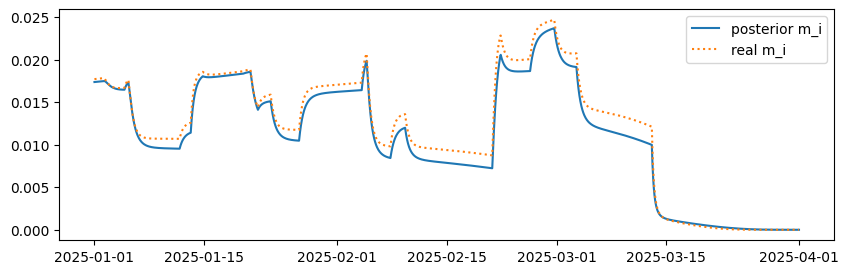

-1.9428255427638939


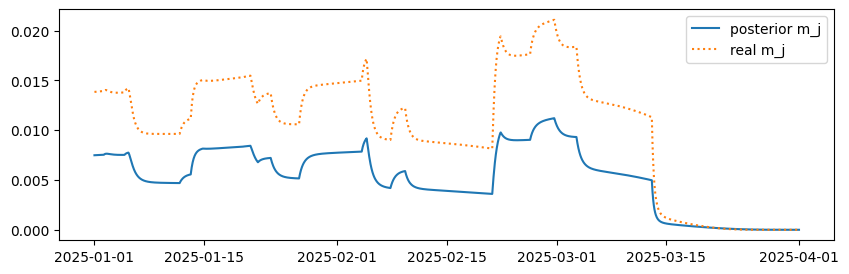

-11.148287691881709


In [16]:
posterior_m_i_mean = fit.stan_variable('m_i').mean(axis=0)
posterior_m_j_mean = fit.stan_variable('m_j').mean(axis=0)

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_i_mean, label='posterior m_i')
plt.plot(np.array(time_grids), i_effort_dynamic, label='real m_i', linestyle='dotted')
plt.legend()
plt.show()
print(np.sum(posterior_m_i_mean - i_effort_dynamic))

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_m_j_mean, label='posterior m_j')
plt.plot(np.array(time_grids), j_effort_dynamic, label='real m_j', linestyle='dotted')
plt.legend()
plt.show()
print(np.sum(posterior_m_j_mean - j_effort_dynamic))

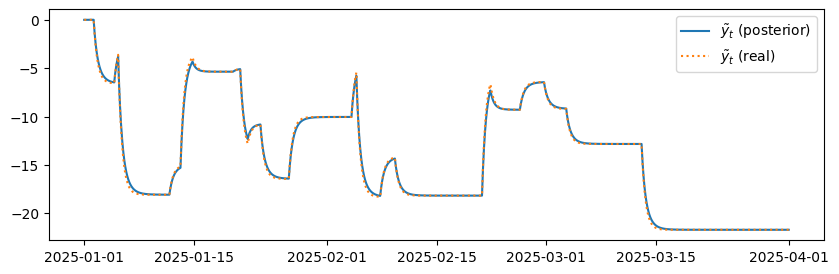

59.33685821604962


In [17]:
## compare posterior \tilde{y}[1]..\tilde{y}[T] with real

posterior_tilde_y_mean = fit.stan_variable('tilde_y').mean(axis=0)

plt.figure(figsize=(10, 3))
plt.plot(np.array(time_grids), posterior_tilde_y_mean[:-1], label=r'$\tilde{y}_t$ (posterior)')
plt.plot(np.array(time_grids), perceived_gap_dynamic[:-1], label=r'$\tilde{y}_t$ (real)', linestyle='dotted')
plt.legend()
plt.show()
print(np.sum(posterior_tilde_y_mean - perceived_gap_dynamic))

### Clean Up

In [18]:
for file in output_dir.iterdir():
	if file.is_file():
		file.unlink()